<a href="https://colab.research.google.com/github/kalkoulim/DS/blob/main/Untitled3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ucimlrepo

In [2]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
forest_fires = fetch_ucirepo(id=162)

# data (as pandas dataframes)
X = forest_fires.data.features
y = forest_fires.data.targets

# metadata
print(forest_fires.metadata)

# variable information
print(forest_fires.variables)


{'uci_id': 162, 'name': 'Forest Fires', 'repository_url': 'https://archive.ics.uci.edu/dataset/162/forest+fires', 'data_url': 'https://archive.ics.uci.edu/static/public/162/data.csv', 'abstract': 'This is a difficult regression task, where the aim is to predict the burned area of forest fires, in the northeast region of Portugal, by using meteorological and other data (see details at: http://www.dsi.uminho.pt/~pcortez/forestfires).', 'area': 'Climate and Environment', 'tasks': ['Regression'], 'characteristics': ['Multivariate'], 'num_instances': 517, 'num_features': 12, 'feature_types': ['Real'], 'demographics': [], 'target_col': ['area'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 2007, 'last_updated': 'Thu Jan 11 2024', 'dataset_doi': '10.24432/C5D88D', 'creators': ['Paulo Cortez', 'Anbal Morais'], 'intro_paper': {'ID': 368, 'type': 'NATIVE', 'title': 'A data mining approach to predict forest fires using meteorological da

In [3]:
# 1. Import des librairies
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR


In [5]:
# 1.1 Chargement des données localement (adapter le chemin)
df = pd.read_csv("/content/drive/MyDrive/forestfires.csv")  # fichier téléchargé depuis l'UCI

# Aperçu
print(df.head())
print(df.info())
print(df.describe())


   X  Y month  day  FFMC   DMC     DC  ISI  temp  RH  wind  rain  area
0  7  5   mar  fri  86.2  26.2   94.3  5.1   8.2  51   6.7   0.0   0.0
1  7  4   oct  tue  90.6  35.4  669.1  6.7  18.0  33   0.9   0.0   0.0
2  7  4   oct  sat  90.6  43.7  686.9  6.7  14.6  33   1.3   0.0   0.0
3  8  6   mar  fri  91.7  33.3   77.5  9.0   8.3  97   4.0   0.2   0.0
4  8  6   mar  sun  89.3  51.3  102.2  9.6  11.4  99   1.8   0.0   0.0
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null

In [6]:
X = df.drop(columns=["area"])
y = df["area"]


In [7]:
# Vérification des doublons
print("Nombre de doublons :", df.duplicated().sum())

# Suppression éventuelle des doublons
df = df.drop_duplicates()

# Vérification des valeurs manquantes
print(df.isna().sum())


Nombre de doublons : 4
X        0
Y        0
month    0
day      0
FFMC     0
DMC      0
DC       0
ISI      0
temp     0
RH       0
wind     0
rain     0
area     0
dtype: int64


In [8]:
# Identification des variables numériques et catégorielles
numeric_features = df.select_dtypes(include=["int64", "float64"]).columns.tolist()
numeric_features.remove("area")  # enlever la cible
categorical_features = df.select_dtypes(include=["object"]).columns.tolist()

from sklearn.impute import SimpleImputer

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)


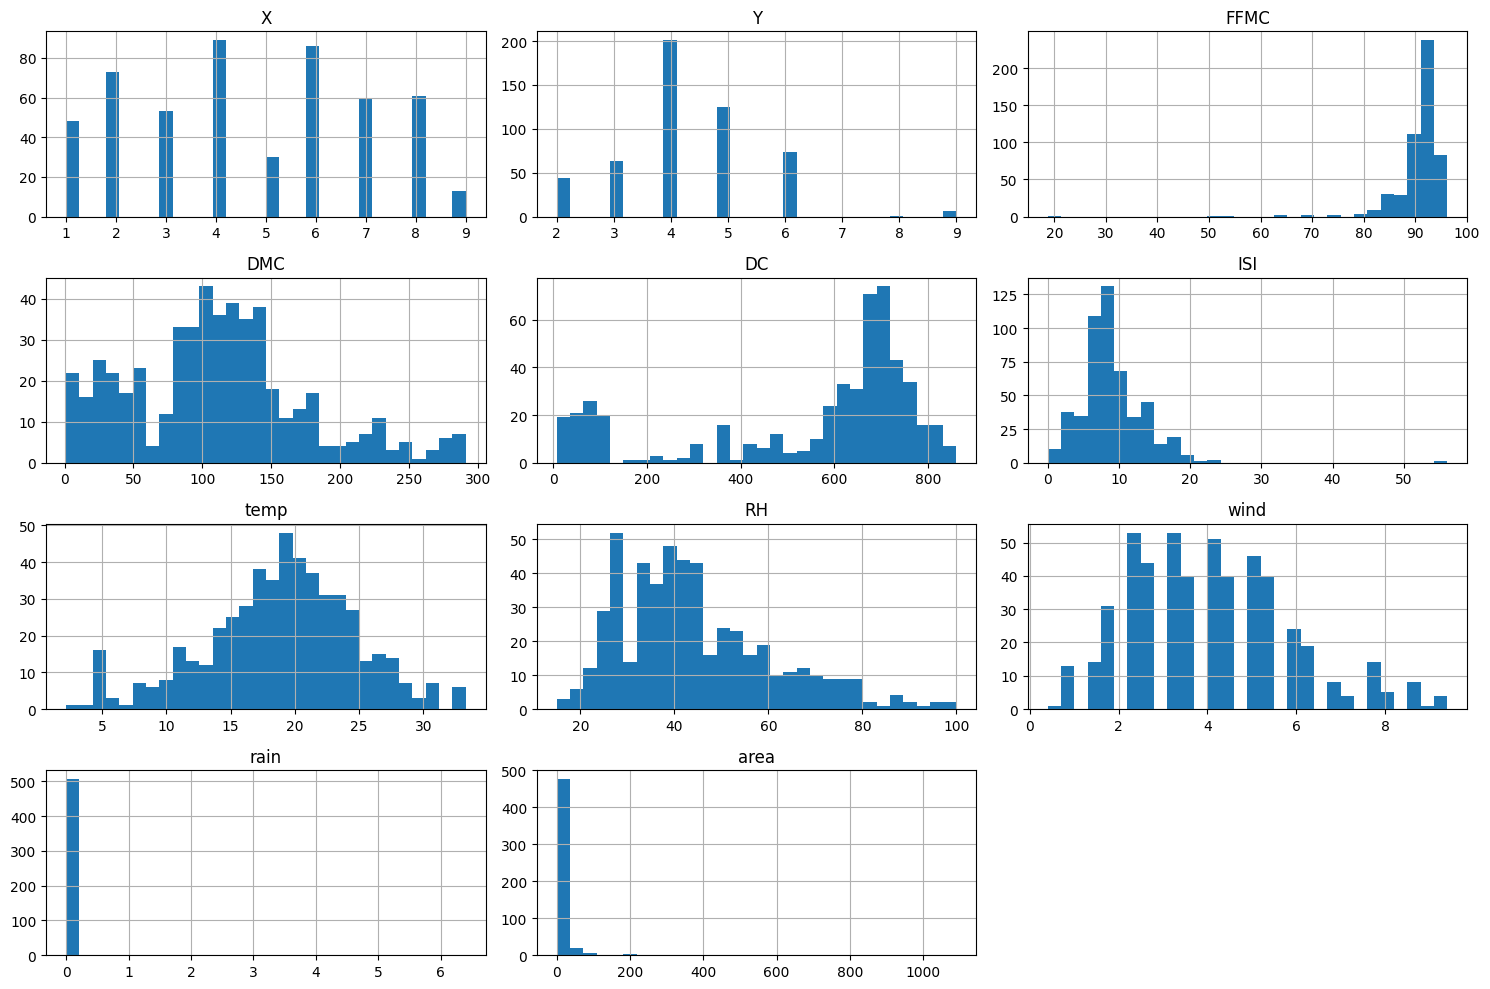

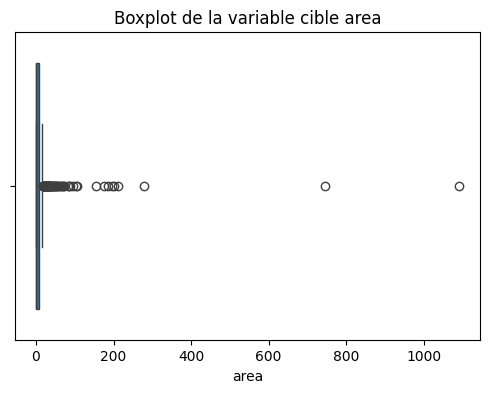

In [9]:
# Histogrammes pour les variables numériques
df[numeric_features + ["area"]].hist(bins=30, figsize=(15, 10))
plt.tight_layout()
plt.show()

# Exemple de boxplot pour la cible (area) très skewed
plt.figure(figsize=(6, 4))
sns.boxplot(x=df["area"])
plt.title("Boxplot de la variable cible area")
plt.show()


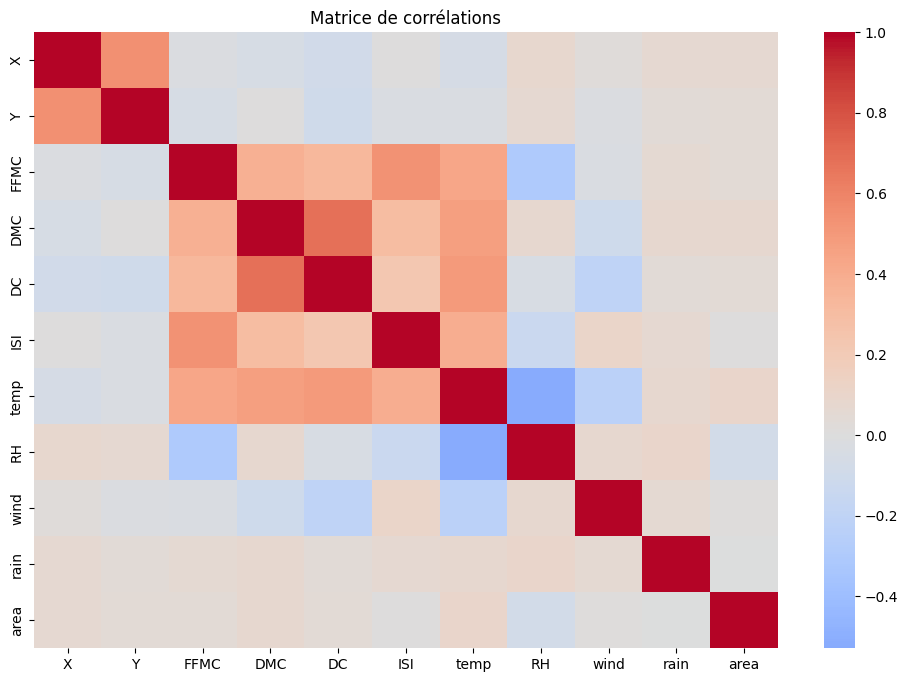

In [10]:
plt.figure(figsize=(12, 8))
corr = df.select_dtypes(include=["int64", "float64"]).corr()
sns.heatmap(corr, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélations")
plt.show()


In [11]:
df["log_area"] = np.log1p(df["area"])  # transformation pour réduire la skewness
y_log = df["log_area"]

# Exemple : indice combinant températures et vent
df["temp_wind_interaction"] = df["temp"] * df["wind"]

# Exemple : saison (spring, summer, autumn, winter) à partir de month
season_map = {
    "jan": "winter", "feb": "winter", "mar": "spring", "apr": "spring",
    "may": "spring", "jun": "summer", "jul": "summer", "aug": "summer",
    "sep": "autumn", "oct": "autumn", "nov": "autumn", "dec": "winter"
}
df["season"] = df["month"].map(season_map)

# Mise à jour des variables
X = df.drop(columns=["area", "log_area"])
y = y_log  # on prévoit log_area
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_features = X.select_dtypes(include=["object"]).columns.tolist()


In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Pipeline Régression Linéaire
pipe_lr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LinearRegression())
])

# Pipeline Random Forest
pipe_rf = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", RandomForestRegressor(random_state=42))
])

# Pipeline SVR
pipe_svr = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", SVR())
])


In [14]:
from sklearn.model_selection import cross_val_score

models = {
    "LinearRegression": pipe_lr,
    "RandomForest": pipe_rf,
    "SVR": pipe_svr
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring="neg_mean_squared_error")
    rmse_scores = np.sqrt(-scores)
    print(f"{name} - RMSE moyen : {rmse_scores.mean():.3f} (+/- {rmse_scores.std():.3f})")


LinearRegression - RMSE moyen : 1.612 (+/- 0.232)
RandomForest - RMSE moyen : 1.512 (+/- 0.049)
SVR - RMSE moyen : 1.516 (+/- 0.149)


In [15]:
param_grid_rf = {
    "model__n_estimators": [50, 100, 200],
    "model__max_depth": [None, 5, 10],
    "model__min_samples_split": [2, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=pipe_rf,
    param_grid=param_grid_rf,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)

print("Meilleurs hyperparamètres RF :", grid_rf.best_params_)
print("Meilleur score CV RF (RMSE) :", np.sqrt(-grid_rf.best_score_))


Meilleurs hyperparamètres RF : {'model__max_depth': 5, 'model__min_samples_split': 10, 'model__n_estimators': 200}
Meilleur score CV RF (RMSE) : 1.4530799807291375


In [16]:
param_grid_svr = {
    "model__kernel": ["rbf", "linear"],
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", "auto"]
}

grid_svr = GridSearchCV(
    estimator=pipe_svr,
    param_grid=param_grid_svr,
    cv=5,
    scoring="neg_mean_squared_error",
    n_jobs=-1
)

grid_svr.fit(X_train, y_train)

print("Meilleurs hyperparamètres SVR :", grid_svr.best_params_)
print("Meilleur score CV SVR (RMSE) :", np.sqrt(-grid_svr.best_score_))


Meilleurs hyperparamètres SVR : {'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'rbf'}
Meilleur score CV SVR (RMSE) : 1.5232546074340525


In [17]:
best_lr = pipe_lr.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_
best_svr = grid_svr.best_estimator_

models_final = {
    "LinearRegression": best_lr,
    "RandomForest": best_rf,
    "SVR": best_svr
}

for name, model in models_final.items():
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"{name} - Test RMSE : {rmse:.3f}, R2 : {r2:.3f}")


LinearRegression - Test RMSE : 1.267, R2 : 0.039
RandomForest - Test RMSE : 1.302, R2 : -0.015
SVR - Test RMSE : 1.318, R2 : -0.040


In [18]:
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)  # pour chaque modèle
